<a href="https://colab.research.google.com/github/suhrudsharma/Adaptive-IOT-Botnet-Detection/blob/main/RP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:

# CELL 1 — Load N-BaIoT CSVs → Create flows.csv


import pandas as pd
import numpy as np

print("Loading N-BaIoT Files...")

# Map your files to labels
file_map = {
    "1.benign.csv":       "benign",
    "1.mirai.scan.csv":   "scan",
    "1.mirai.syn.csv":    "infect",
    "1.mirai.udp.csv":    "infect",
    "1.gafgyt.scan.csv":  "scan",
    "1.gafgyt.tcp.csv":   "c2",
    "1.gafgyt.udp.csv":   "c2"
}

dfs = []

# Load each file and add label
for fname, label in file_map.items():
    print(f"Loading {fname} → label = {label}")
    df = pd.read_csv(fname)
    df["label"] = label
    dfs.append(df)

# Merge into one dataset
df = pd.concat(dfs, ignore_index=True)

# Clean column names
df.columns = df.columns.str.lower().str.strip()

# Add synthetic metadata (IoT flows)
df["timestamp"] = pd.to_datetime(1700000000 + df.index * 0.1, unit="s")
df["src_ip"] = "192.168.1.10"
df["dst_ip"] = "10.0.0.5"
df["dst_port"] = 80
df["flag"] = "CON"

# Choose some numeric columns for packets/bytes/duration
numeric_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()

df["packets"] = df[numeric_cols].iloc[:, 0]
df["bytes"]   = df[numeric_cols].iloc[:, 1]
df["flow_duration"] = df[numeric_cols].iloc[:, 2]

# FINAL columns
df = df[[
    "timestamp", "src_ip", "dst_ip", "dst_port",
    "packets", "bytes", "flow_duration", "flag", "label"
]]

# Save output
df.to_csv("flows.csv", index=False)

print("\nflows.csv created successfully!")
print("Label distribution:")
print(df["label"].value_counts())


Loading N-BaIoT Files...
Loading 1.benign.csv → label = benign
Loading 1.mirai.scan.csv → label = scan
Loading 1.mirai.syn.csv → label = infect
Loading 1.mirai.udp.csv → label = infect
Loading 1.gafgyt.scan.csv → label = scan
Loading 1.gafgyt.tcp.csv → label = c2
Loading 1.gafgyt.udp.csv → label = c2

flows.csv created successfully!
Label distribution:
label
infect    360238
c2        198015
scan      137534
benign     49548
Name: count, dtype: int64


In [15]:

# CELL 2 — Windowing + Feature Extraction


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Loading flows.csv...")
df = pd.read_csv("flows.csv", parse_dates=["timestamp"])

# 1. Convert timestamp to integer seconds
df["ts_sec"] = df["timestamp"].astype("int64") // 10**9

# 2. Window size (3 seconds)
WINDOW = 3
min_ts = df["ts_sec"].min()
max_ts = df["ts_sec"].max()

bins = list(range(min_ts, max_ts + WINDOW, WINDOW))
df["window"] = np.digitize(df["ts_sec"], bins) - 1

# 3. Aggregate features per WINDOW
rows = []

for w in sorted(df["window"].unique()):
    wdf = df[df["window"] == w]
    if len(wdf) == 0:
        continue

    # --- SIMPLE FEATURES ---
    pkt = wdf["packets"].sum()
    byt = wdf["bytes"].sum()
    mean_pkt = byt / pkt if pkt > 0 else 0

    dest_count = wdf["dst_ip"].nunique()
    port_count = wdf["dst_port"].nunique()

    fail_ratio = (wdf["flag"] == "REJECT").mean()

    dur = wdf["flow_duration"].mean()

    # Interarrival time stability
    if len(wdf) > 1:
        inter_std = wdf["timestamp"].diff().dt.total_seconds().std()
    else:
        inter_std = 0

    same_dest_flows = wdf.groupby("dst_ip").size().max()

    # LABELS for the 3 modules
    rows.append({
        "window": w,
        "packet_count": pkt,
        "bytes_sent": byt,
        "bytes_received": byt,
        "mean_packet_size": mean_pkt,
        "dest_ip_count": dest_count,
        "distinct_ports_count": port_count,
        "failed_conn_ratio": fail_ratio,
        "flow_duration_mean": dur,
        "interarrival_time_std": inter_std,
        "same_dest_flow_count": same_dest_flows,

        # 1-vs-rest labels
        "label_scan": int((wdf["label"] == "scan").any()),
        "label_c2": int((wdf["label"] == "c2").any()),
        "label_infect": int((wdf["label"] == "infect").any())
    })

agg = pd.DataFrame(rows)

print("Total windows:", len(agg))

# 4. Select features
features = [
    "packet_count","bytes_sent","bytes_received","mean_packet_size",
    "dest_ip_count","distinct_ports_count","failed_conn_ratio",
    "flow_duration_mean","interarrival_time_std","same_dest_flow_count"
]

X = agg[features].fillna(0)
y_scan = agg["label_scan"]
y_c2 = agg["label_c2"]
y_inf = agg["label_infect"]

# 5. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Train-test split
X_train, X_test, y_scan_train, y_scan_test = train_test_split(
    X_scaled, y_scan, test_size=0.2, random_state=42
)

_, _, y_c2_train, y_c2_test = train_test_split(
    X_scaled, y_c2, test_size=0.2, random_state=42
)

_, _, y_inf_train, y_inf_test = train_test_split(
    X_scaled, y_inf, test_size=0.2, random_state=42
)

# 7. Save to disk
pd.DataFrame(X_train).to_csv("X_train.csv", index=False)
pd.DataFrame(X_test).to_csv("X_test.csv", index=False)

pd.DataFrame(y_scan_train).to_csv("y_scan_train.csv", index=False)
pd.DataFrame(y_scan_test).to_csv("y_scan_test.csv", index=False)

pd.DataFrame(y_c2_train).to_csv("y_c2_train.csv", index=False)
pd.DataFrame(y_c2_test).to_csv("y_c2_test.csv", index=False)

pd.DataFrame(y_inf_train).to_csv("y_inf_train.csv", index=False)
pd.DataFrame(y_inf_test).to_csv("y_inf_test.csv", index=False)

print("\nFeature extraction complete!")
print("X_train shape:", X_train.shape)


Loading flows.csv...
Total windows: 24845

Feature extraction complete!
X_train shape: (19876, 10)


In [16]:

# CELL 3 — Train 3 Simple Modular Models


import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Load data
X_train = pd.read_csv("X_train.csv").values.astype("float32")
X_test  = pd.read_csv("X_test.csv").values.astype("float32")

y_scan_train = pd.read_csv("y_scan_train.csv").values.ravel()
y_scan_test  = pd.read_csv("y_scan_test.csv").values.ravel()

y_c2_train = pd.read_csv("y_c2_train.csv").values.ravel()
y_c2_test  = pd.read_csv("y_c2_test.csv").values.ravel()

y_inf_train = pd.read_csv("y_inf_train.csv").values.ravel()
y_inf_test  = pd.read_csv("y_inf_test.csv").values.ravel()

INPUT_DIM = X_train.shape[1]

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="relu", input_shape=(INPUT_DIM,)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ------------------------
# 1) Train Scan Module
# ------------------------
print("\nTraining Scan Model...")
scan_model = build_model()
scan_model.fit(X_train, y_scan_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
scan_model.save("scan_model.h5")

y_scan_pred = (scan_model.predict(X_test) > 0.5).astype(int)
print("\nScan Classification Report:")
print(classification_report(y_scan_test, y_scan_pred))


# ------------------------
# 2) Train C2 Module
# ------------------------
print("\nTraining C2 Model...")
c2_model = build_model()
c2_model.fit(X_train, y_c2_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
c2_model.save("c2_model.h5")

y_c2_pred = (c2_model.predict(X_test) > 0.5).astype(int)
print("\nC2 Classification Report:")
print(classification_report(y_c2_test, y_c2_pred))


# ------------------------
# 3) Train Infection Module
# ------------------------
print("\nTraining Infection Model...")
inf_model = build_model()
inf_model.fit(X_train, y_inf_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
inf_model.save("inf_model.h5")

y_inf_pred = (inf_model.predict(X_test) > 0.5).astype(int)
print("\nInfection Classification Report:")
print(classification_report(y_inf_test, y_inf_pred))

print("\n Training Complete! Models saved:")
print("• scan_model.h5")
print("• c2_model.h5")
print("• inf_model.h5")



Training Scan Model...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9219 - loss: 0.2814 - val_accuracy: 0.9449 - val_loss: 0.1097
Epoch 2/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9473 - loss: 0.1056 - val_accuracy: 0.9545 - val_loss: 0.1008
Epoch 3/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9536 - loss: 0.0953 - val_accuracy: 0.9532 - val_loss: 0.0925
Epoch 4/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9570 - loss: 0.0881 - val_accuracy: 0.9671 - val_loss: 0.0828
Epoch 5/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9718 - loss: 0.0712 - val_accuracy: 0.9794 - val_loss: 0.0797
Epoch 6/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9837 - loss: 0.0557 - val_accuracy: 0.9940 - val_loss: 0.0896
Epoch 7/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9895 - loss: 0.0500 - val_accuracy: 0.9952 - val_loss: 0.0979
Epoch 8/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9929 - loss: 0.0396 - val_accuracy: 0.9950 - val_

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Scan Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4043
           1       0.99      0.98      0.98       926

    accuracy                           0.99      4969
   macro avg       0.99      0.99      0.99      4969
weighted avg       0.99      0.99      0.99      4969


Training C2 Model...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9041 - loss: 0.2708 - val_accuracy: 0.9997 - val_loss: 0.0131
Epoch 2/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 0.0092 - val_accuracy: 0.9997 - val_loss: 0.0029
Epoch 3/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 0.0025 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 4/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 5/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.0041 - val_accuracy: 0.9997 - val_loss: 8.4144e-04
Epoch 6/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 7.4247e-04 - val_accuracy: 0.9997 - val_loss: 7.6781e-04
Epoch 7/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9997 - val_loss: 4.5112e-04
Epoch 8/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accurac

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3638
           1       1.00      1.00      1.00      1331

    accuracy                           1.00      4969
   macro avg       1.00      1.00      1.00      4969
weighted avg       1.00      1.00      1.00      4969


Training Infection Model...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


497/497 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8791 - loss: 0.3309 - val_accuracy: 0.9454 - val_loss: 0.1162
Epoch 2/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9462 - loss: 0.1085 - val_accuracy: 0.9482 - val_loss: 0.1009
Epoch 3/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9510 - loss: 0.0994 - val_accuracy: 0.9565 - val_loss: 0.0909
Epoch 4/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9599 - loss: 0.0879 - val_accuracy: 0.9650 - val_loss: 0.0781
Epoch 5/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9719 - loss: 0.0743 - val_accuracy: 0.9746 - val_loss: 0.0606
Epoch 6/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9850 - loss: 0.0551 - val_accuracy: 0.9879 - val_loss: 0.0431
Epoch 7/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9935 - loss: 0.0400 - val_accuracy: 0.9965 - val_loss: 0.0313
Epoch 8/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9965 - loss: 0.0304 - val_accuracy: 0.9967 - val_

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Infection Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2583
           1       0.99      1.00      0.99      2386

    accuracy                           0.99      4969
   macro avg       0.99      0.99      0.99      4969
weighted avg       0.99      0.99      0.99      4969


 Training Complete! Models saved:
• scan_model.h5
• c2_model.h5
• inf_model.h5


Loading models and test data...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


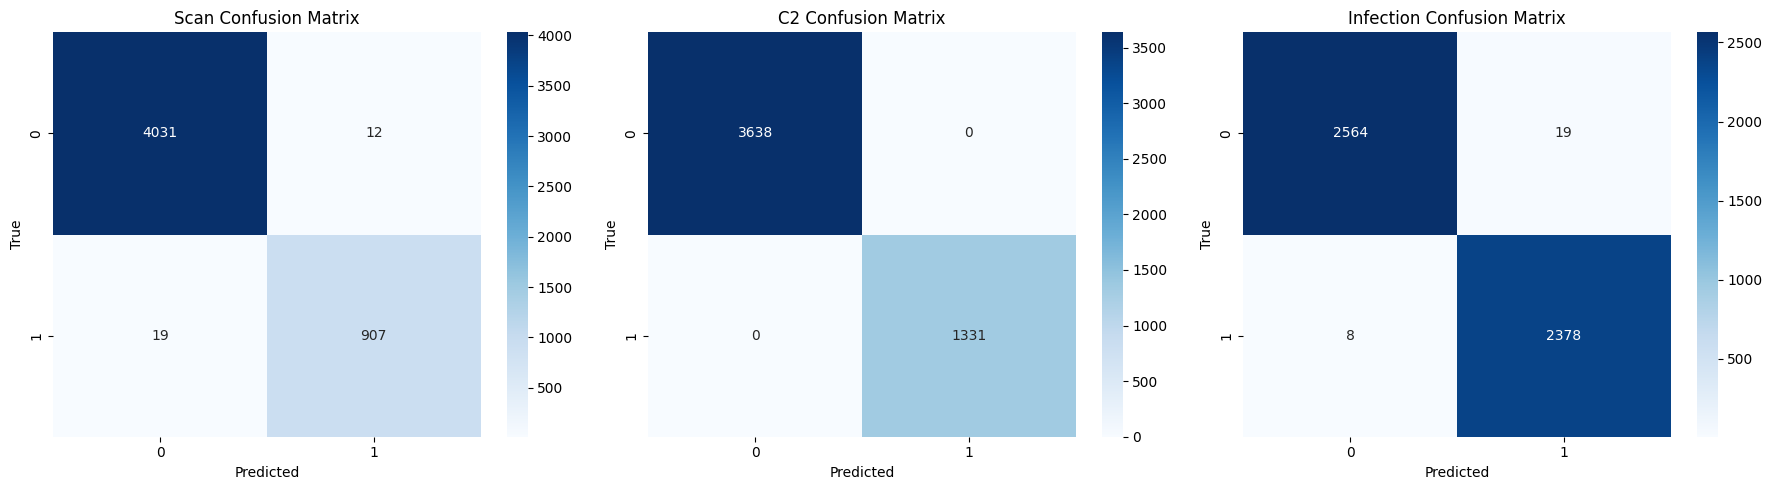

In [17]:

# CELL 4 — Confusion Matrices + Heatmaps


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import tensorflow as tf

print("Loading models and test data...")

X_test  = pd.read_csv("X_test.csv").values.astype("float32")
y_scan_test = pd.read_csv("y_scan_test.csv").values.ravel()
y_c2_test   = pd.read_csv("y_c2_test.csv").values.ravel()
y_inf_test  = pd.read_csv("y_inf_test.csv").values.ravel()

scan_model = tf.keras.models.load_model("scan_model.h5")
c2_model   = tf.keras.models.load_model("c2_model.h5")
inf_model  = tf.keras.models.load_model("inf_model.h5")

# Predictions
y_scan_pred = (scan_model.predict(X_test) > 0.5).astype(int)
y_c2_pred   = (c2_model.predict(X_test) > 0.5).astype(int)
y_inf_pred  = (inf_model.predict(X_test) > 0.5).astype(int)

# Confusion matrices
cm_scan = confusion_matrix(y_scan_test, y_scan_pred)
cm_c2   = confusion_matrix(y_c2_test, y_c2_pred)
cm_inf  = confusion_matrix(y_inf_test, y_inf_pred)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_cm(cm, ax, title):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plot_cm(cm_scan, axes[0], "Scan Confusion Matrix")
plot_cm(cm_c2, axes[1], "C2 Confusion Matrix")
plot_cm(cm_inf, axes[2], "Infection Confusion Matrix")

plt.tight_layout()
plt.show()


In [18]:

# CELL 5 — Final Modular Combiner (Edge Logic)


import numpy as np
import pandas as pd
import tensorflow as tf

print("Loading trained models...")

scan_model = tf.keras.models.load_model("scan_model.h5")
c2_model   = tf.keras.models.load_model("c2_model.h5")
inf_model  = tf.keras.models.load_model("inf_model.h5")

# Compile after loading
scan_model.compile(optimizer='adam', loss='binary_crossentropy')
c2_model.compile(optimizer='adam', loss='binary_crossentropy')
inf_model.compile(optimizer='adam', loss='binary_crossentropy')

print("All models loaded successfully.\n")

# -------------------------------
# FINAL DECISION FUNCTION
# -------------------------------

def final_decision(feature_vector):
    fv = feature_vector.reshape(1, -1)

    p_scan = float(scan_model.predict(fv, verbose=0)[0][0])
    p_c2   = float(c2_model.predict(fv, verbose=0)[0][0])
    p_inf  = float(inf_model.predict(fv, verbose=0)[0][0])

    print("\n--- Module Scores ---")
    print(f"Scan Score:      {p_scan:.4f}")
    print(f"C2 Score:        {p_c2:.4f}")
    print(f"Infection Score: {p_inf:.4f}")

    # Priority order (same as original research)
    if p_scan > 0.5:
        return "SCANNING DETECTED"
    if p_c2 > 0.5:
        return "C2 COMMAND DETECTED"
    if p_inf > 0.5:
        return "INFECTION DETECTED"
    return "BENIGN"


# -------------------------------
# TEST THE COMBINER
# -------------------------------
print("Testing final modular network on sample windows...\n")

X_test = pd.read_csv("X_test.csv").values.astype("float32")

for i in range(5):
    print(f"\nSample #{i+1}")
    decision = final_decision(X_test[i])
    print("Final Decision:", decision)


Loading trained models...
All models loaded successfully.

Testing final modular network on sample windows...


Sample #1



--- Module Scores ---
Scan Score:      0.0000
C2 Score:        0.0000
Infection Score: 1.0000
Final Decision: INFECTION DETECTED

Sample #2

--- Module Scores ---
Scan Score:      0.0000
C2 Score:        0.9997
Infection Score: 0.0000
Final Decision: C2 COMMAND DETECTED

Sample #3

--- Module Scores ---
Scan Score:      0.2602
C2 Score:        0.0000
Infection Score: 0.8879
Final Decision: INFECTION DETECTED

Sample #4

--- Module Scores ---
Scan Score:      0.0000
C2 Score:        0.9997
Infection Score: 0.0000
Final Decision: C2 COMMAND DETECTED

Sample #5

--- Module Scores ---
Scan Score:      0.0000
C2 Score:        0.0000
Infection Score: 1.0000
Final Decision: INFECTION DETECTED


In [19]:

# CELL 6 — Adaptive Retraining (C2 Module)


import os
import numpy as np
import pandas as pd
import tensorflow as tf

print("Starting Adaptive Retraining...")

# Load stored C2 model
c2_model = tf.keras.models.load_model("c2_model.h5")
c2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load original training data
X_train = pd.read_csv("X_train.csv").values.astype("float32")
y_c2_train = pd.read_csv("y_c2_train.csv").values.ravel()

# Simulate “new suspicious packets” collected at the edge
# Here we simply reuse 50 samples from test
X_test = pd.read_csv("X_test.csv").values.astype("float32")

buffer_size = min(50, len(X_test))
buffer_X = X_test[:buffer_size]
buffer_y = np.ones(buffer_size)   # mark as attack for retraining

print(f"Adaptive buffer size: {buffer_size} samples")

# Merge original + new data
X_new = np.vstack([X_train, buffer_X]).astype("float32")
y_new = np.concatenate([y_c2_train, buffer_y]).astype("float32")

print("Retraining C2 model on combined dataset...")

# Retrain only C2
c2_model.fit(X_new, y_new, epochs=5, batch_size=32, verbose=1)

# Save adapted model
c2_model.save("c2_model_adapted.h5")

print("\n Adaptive retraining complete!")
print("Updated model saved as: c2_model_adapted.h5")


Starting Adaptive Retraining...
Adaptive buffer size: 50 samples
Retraining C2 model on combined dataset...
Epoch 1/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9984 - loss: 0.0207
Epoch 2/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9980 - loss: 0.0158
Epoch 3/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.0097
Epoch 4/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9984 - loss: 0.0121
Epoch 5/5
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9984 - loss: 0.0116



 Adaptive retraining complete!
Updated model saved as: c2_model_adapted.h5


In [20]:

# CELL 7 — Convert Models to TFLite (Edge Deployment)


import tensorflow as tf
import os

print("Starting TFLite conversion...")

def convert(model_path, output_path):
    if not os.path.exists(model_path):
        print(f" Model missing: {model_path}")
        return

    model = tf.keras.models.load_model(model_path)

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # Optimize for size + speed (best for IoT)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_model = converter.convert()

    with open(output_path, "wb") as f:
        f.write(tflite_model)

    size_kb = os.path.getsize(output_path) / 1024
    print(f" Saved {output_path} ({size_kb:.2f} KB)")

# Convert all 3 main models
convert("scan_model.h5", "scan_model.tflite")
convert("c2_model.h5", "c2_model.tflite")
convert("inf_model.h5", "inf_model.tflite")

# Convert adapted C2 model
convert("c2_model_adapted.h5", "c2_model_adapted.tflite")

print("\n TFLite conversion complete!")


Starting TFLite conversion...
Saved artifact at '/tmp/tmpzn9undls'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133407099342864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407099343056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407099342096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407099342288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407099344976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133409922255376: TensorSpec(shape=(), dtype=tf.resource, name=None)
 Saved scan_model.tflite (5.59 KB)


Saved artifact at '/tmp/tmplxq4pp58'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133407055634960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055634384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055261200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055263312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407191233168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055250832: TensorSpec(shape=(), dtype=tf.resource, name=None)
 Saved c2_model.tflite (5.54 KB)


Saved artifact at '/tmp/tmpc5uw_h_x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133407055628816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055259856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055255248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055260240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055257744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407056232912: TensorSpec(shape=(), dtype=tf.resource, name=None)
 Saved inf_model.tflite (5.54 KB)


Saved artifact at '/tmp/tmpp6ap23cz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133407055264464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055258320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055251216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055256784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055255824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133407055255632: TensorSpec(shape=(), dtype=tf.resource, name=None)
 Saved c2_model_adapted.tflite (5.54 KB)

 TFLite conversion complete!


In [21]:

# CELL 8 — FINAL MODULAR MNN DECISION SYSTEM


import numpy as np
import pandas as pd
import tensorflow as tf

print("Loading trained models...")

scan_model = tf.keras.models.load_model("scan_model.h5")
c2_model   = tf.keras.models.load_model("c2_model.h5")
inf_model  = tf.keras.models.load_model("inf_model.h5")

# Compile for safety
scan_model.compile(optimizer='adam', loss='binary_crossentropy')
c2_model.compile(optimizer='adam', loss='binary_crossentropy')
inf_model.compile(optimizer='adam', loss='binary_crossentropy')

print("All models loaded successfully.\n")

# -----------------------------
# FINAL DECISION ENGINE
# -----------------------------
def final_detection(feature_vector):
    fv = feature_vector.reshape(1, -1)

    p_scan = float(scan_model.predict(fv, verbose=0)[0][0])
    p_c2   = float(c2_model.predict(fv, verbose=0)[0][0])
    p_inf  = float(inf_model.predict(fv, verbose=0)[0][0])

    print("\n--- Module Scores ---")
    print(f"Scan Score:      {p_scan:.4f}")
    print(f"C2 Score:        {p_c2:.4f}")
    print(f"Infection Score: {p_inf:.4f}")

    # Priority logic
    if p_scan > 0.5: return "SCAN ATTACK DETECTED"
    if p_c2 > 0.5:   return "C2 COMMAND DETECTED"
    if p_inf > 0.5:  return "INFECTION DETECTED"

    return "BENIGN"

# Load test dataset
X_test = pd.read_csv("X_test.csv").values.astype('float32')

print("Testing final modular network on sample windows...\n")

# Test 5 random windows
for i in range(5):
    print(f"\nSample #{i+1}")
    decision = final_detection(X_test[i])
    print("Final Decision:", decision)


Loading trained models...
All models loaded successfully.

Testing final modular network on sample windows...


Sample #1

--- Module Scores ---
Scan Score:      0.0000
C2 Score:        0.0000
Infection Score: 1.0000
Final Decision: INFECTION DETECTED

Sample #2

--- Module Scores ---
Scan Score:      0.0000
C2 Score:        0.9997
Infection Score: 0.0000
Final Decision: C2 COMMAND DETECTED

Sample #3

--- Module Scores ---
Scan Score:      0.2602
C2 Score:        0.0000
Infection Score: 0.8879
Final Decision: INFECTION DETECTED

Sample #4

--- Module Scores ---
Scan Score:      0.0000
C2 Score:        0.9997
Infection Score: 0.0000
Final Decision: C2 COMMAND DETECTED

Sample #5

--- Module Scores ---
Scan Score:      0.0000
C2 Score:        0.0000
Infection Score: 1.0000
Final Decision: INFECTION DETECTED


In [22]:
!ls

1.benign.csv	   c2_model_adapted.h5	    sample_data        y_inf_test.csv
1.gafgyt.scan.csv  c2_model_adapted.tflite  scan_model.h5      y_inf_train.csv
1.gafgyt.tcp.csv   c2_model.h5		    scan_model.tflite  y_scan_test.csv
1.gafgyt.udp.csv   c2_model.tflite	    X_test.csv	       y_scan_train.csv
1.mirai.scan.csv   flows.csv		    X_train.csv
1.mirai.syn.csv    inf_model.h5		    y_c2_test.csv
1.mirai.udp.csv    inf_model.tflite	    y_c2_train.csv


In [23]:
import os
os.listdir()


['.config',
 '1.gafgyt.udp.csv',
 'c2_model_adapted.tflite',
 'c2_model.tflite',
 'y_inf_train.csv',
 'inf_model.tflite',
 'y_c2_train.csv',
 'c2_model.h5',
 '1.mirai.syn.csv',
 'scan_model.h5',
 '1.mirai.udp.csv',
 '1.benign.csv',
 'scan_model.tflite',
 'y_c2_test.csv',
 'y_scan_train.csv',
 'inf_model.h5',
 '1.gafgyt.scan.csv',
 'y_inf_test.csv',
 'y_scan_test.csv',
 'X_test.csv',
 '1.gafgyt.tcp.csv',
 '1.mirai.scan.csv',
 'X_train.csv',
 'c2_model_adapted.h5',
 'flows.csv',
 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
